In [4]:
import sys
sys.path.append("..")
from preprocess.tile import tile_image
from smart_open import smart_open
import s3fs
from os import path, environ
import rasterio as rio
from re import match
import boto3

from tqdm import tqdm

from numpy.random import randint

from functools import partial

from concurrent import futures

environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

# Tile Large Downloaded Images



In [5]:
# configuration
BUCKET = 'planet-snowcover-imagery'
AWS_PROFILE = 'esip'
IMG_REGEX = ".*_SR_.*\.tif"

In [6]:
# open s3 as filesystem with boto3 credentials
fs = s3fs.S3FileSystem(session= boto3.Session(profile_name = AWS_PROFILE))

In [12]:
# read files, pull out SR images 
files = fs.ls(BUCKET)
images = [f for f in files if match(IMG_REGEX, f)]

In [14]:
# tile all images (takes a while [~3m]). WRITES TO s3!
images = images
outputs = []
for image in tqdm(images, total = len(images), unit='image'):
    imsize = fs.info(image, refresh=True)['Size'] 
    outputdir = path.splitext(image)[0] + '_tiled'
    if fs.exists(outputdir):
        print('{} already exists. Delete to re-create.'.format(outputdir))
        continue # skip
        
    if (imsize == 0):
        print("skipping {}, (size:{})".format(image, imsize))
        continue #skip 
        
    try:
        
        
        res = tile_image('s3://'+image,
                         's3://'+outputdir,
                         indexes=[1,2,3,4], zoom=15,
                         quant = 10000,
                         aws_profile = 'esip')
        outputs.append(res)
    except Exception as e:
        outputs.append(e)
        continue 
        


 20%|██        | 1/5 [00:00<00:01,  2.87image/s]

planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_SR_clip_tiled already exists. Delete to re-create.
planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip_tiled already exists. Delete to re-create.


 80%|████████  | 4/5 [00:00<00:00,  3.73image/s]

skipping planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_SR_clip_scaled.tif, (size:0)
planet-snowcover-imagery/20180601_181450_0f32_3B_AnalyticMS_SR_clip_tiled already exists. Delete to re-create.


100%|██████████| 5/5 [00:01<00:00,  4.14image/s]

planet-snowcover-imagery/20180601_181451_0f32_3B_AnalyticMS_SR_clip_tiled already exists. Delete to re-create.


In [34]:
# check results
directories = [d for d in fs.ls(BUCKET, refresh=True) if match('.*_tiled', d)]

In [36]:
print('dir\ttiles')
for d in directories:
    print("{}\t{}".format(d, len(fs.walk(d))))

dir	tiles
planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip_tiled	366
planet-snowcover-imagery/20180601_181450_0f32_3B_AnalyticMS_SR_clip_tiled	366
planet-snowcover-imagery/20180601_181451_0f32_3B_AnalyticMS_SR_clip_tiled	378


In [23]:
fs.ls('planet-snowcover-snow')

['planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601',
 'planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles',
 'planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles_02']

In [24]:
# attempt to load

In [3]:
sys.path.append("/home/jovyan/work/robosat.pink/")

In [4]:
from robosat_pink.datasets import *

In [5]:
oncat = SlippyMapTilesConcatenation(path='s3://planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip_tiled', target='s3://planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles_02')

In [8]:
data = oncat[0]

In [10]:
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline

In [116]:
data = oncat[randint(0, len(oncat))]


Text(0.5, 1.0, 'mask')

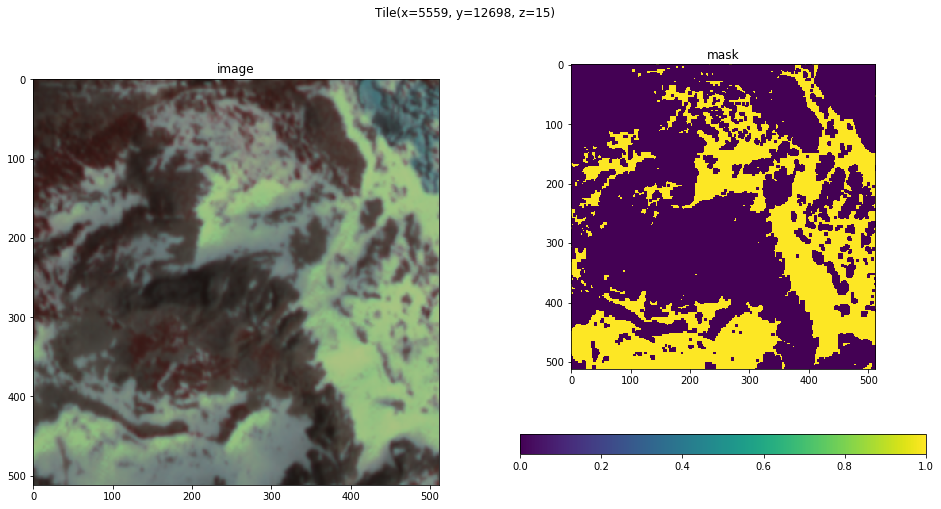

In [151]:

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
fig.suptitle(data[2])
#ax[0].imshow(np.rollaxis(data[0][[2,1,0], :, :], 0, 3))

cm = plt.cm.viridis
im = ax[0].imshow(np.rollaxis(data[0][[3,2,1], :, :], 0, 3), interpolation='nearest')
#im = ax[0].imshow(data[0][1, :, :], interpolation='nearest', cmap = cm)
#fig.colorbar(im, ax=ax[0], orientation = 'horizontal')
ax[0].set_title("image")


im = ax[1].imshow(data[1].squeeze().astype('uint8'), interpolation='nearest', cmap = cm)
fig.colorbar(im, ax=ax[1], orientation = 'horizontal')
ax[1].set_title('mask')





In [87]:
import numpy as np
np.rollaxis(data[0][[3,2,1], :, :], 0, 3).shape

(512, 512, 3)

In [123]:
from PIL import Image

In [138]:
Image.fromarray(data[1].squeeze())

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=512x512 at 0x7FFA7953A6D8>

In [150]:
np.array(Image.fromarray(data[1].squeeze()).convert("P")).dtype

dtype('uint8')